# Pairwise correlation for robust feature selection

* Feature selection is important to remove redundant features, reduce model complexity, and avoid overfitting
* Some techniques focus on removal of features based on individual properties
* Pairwise correlation examines the connection between features and decides if they are worth keeping


### Pearson's correlation coefficient

* Quantifies the linear relationship between two distributions (or features) in a single metric
* Symbol is `r` with range [-1, 1]
  * -1 is a perfect negative correlation
  * +1 is a perfect positive correlation
  * strong correlation: 0.7 <= |r| < 1.0
  * moderate correlation: 0.3 <= |r| < 0.7
  * weak correlation: 0.0 <= |r| < 0.3


### How Pearson correlation is used in feature selection

* Let's say that the Pearson correlation between two feaures is 0.85
* This means that 85% of the time, you can predict feature 2 by using the values of feature 1
* If you have feature 1 in your dataset, feature 2 is not adding much information
* You can remove feature 2 since it only adds more complexity to our trained model
* Pairwise correlation identifies groups of highly correlated features and only keeps one of them
* The model has high predictive power using fewer features


### How to identify highly correlated features

* Plot a correlation matrix

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_correlation_matrix(df: pd.DataFrame, figsize):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap=cmap, ax=ax)


def get_numerical_features(df: pd.DataFrame):
    numerical_features = df.select_dtypes(include='number').columns.tolist()
    return numerical_features


def get_categorical_features(df: pd.DataFrame): 
    categorical_features = df.select_dtypes(exclude='number').columns.tolist()
    return categorical_features


def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]
    
    return to_drop

### Load dataset

* Melborne, Australia dataset

In [3]:
FILE_PATH = "/workspaces/feature_selection/data/"
houses = pd.read_csv(FILE_PATH + "Melbourne_housing_FULL.csv")
houses.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


### EDA

* Identify numerical and categorical features

In [4]:
# Numerical features
numerical_features = get_numerical_features(houses)
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')

# Categorical features
categorical_features = get_categorical_features(houses)
print(f'There are {len(categorical_features)} categorical features:')
print(categorical_features, '\n')

houses_numerical = houses[numerical_features]
houses_numerical.head()

There are 13 numerical features:
['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'] 

There are 8 categorical features:
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname'] 



,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,NaN,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,-37.8014,144.9958,4019.0
1,2,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,4019.0
2,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
3,3,NaN,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,-37.8114,145.0116,4019.0
4,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0


### Plot correlation matrix

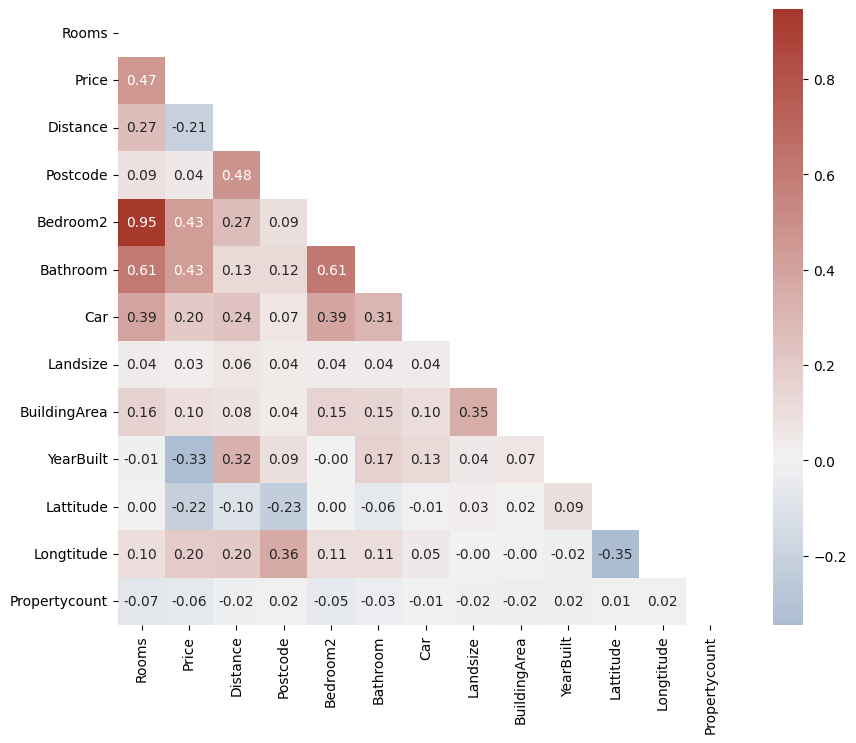

In [5]:
plot_correlation_matrix(houses_numerical, figsize=(10, 8))

### Removing highly correlated features

* The correlation matrix is a great visual summary of our pairs of features
* Can use it to eliminate features
* However, what if we have a large dataset with many features? We could not visualize it
* Example is the Ansur dataset


### Load Ansur dataset

In [6]:
ansur = pd.read_csv(FILE_PATH + "ANSUR II MALE Public.csv", encoding='latin').drop('subjectid', axis=1)
ansur.head()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,266,1467,337,222,1347,253,202,401,369,274,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,233,1395,326,220,1293,245,193,394,338,257,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,287,1430,341,230,1327,256,196,427,408,261,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,234,1347,310,230,1239,262,199,401,359,262,...,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,250,1585,372,247,1478,267,224,435,356,263,...,Combat Service Support,92G,North Carolina,2,NaN,2,21,77,213,Right hand


In [7]:
numerical_features = get_numerical_features(ansur)
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')

There are 98 numerical features:
['abdominalextensiondepthsitting', 'acromialheight', 'acromionradialelength', 'anklecircumference', 'axillaheight', 'balloffootcircumference', 'balloffootlength', 'biacromialbreadth', 'bicepscircumferenceflexed', 'bicristalbreadth', 'bideltoidbreadth', 'bimalleolarbreadth', 'bitragionchinarc', 'bitragionsubmandibulararc', 'bizygomaticbreadth', 'buttockcircumference', 'buttockdepth', 'buttockheight', 'buttockkneelength', 'buttockpopliteallength', 'calfcircumference', 'cervicaleheight', 'chestbreadth', 'chestcircumference', 'chestdepth', 'chestheight', 'crotchheight', 'crotchlengthomphalion', 'crotchlengthposterioromphalion', 'earbreadth', 'earlength', 'earprotrusion', 'elbowrestheight', 'eyeheightsitting', 'footbreadthhorizontal', 'footlength', 'forearmcenterofgriplength', 'forearmcircumferenceflexed', 'forearmforearmbreadth', 'forearmhandlength', 'functionalleglength', 'handbreadth', 'handcircumference', 'handlength', 'headbreadth', 'headcircumference',

### plot correlation matrix

* 98 numerical features are difficult to visualize

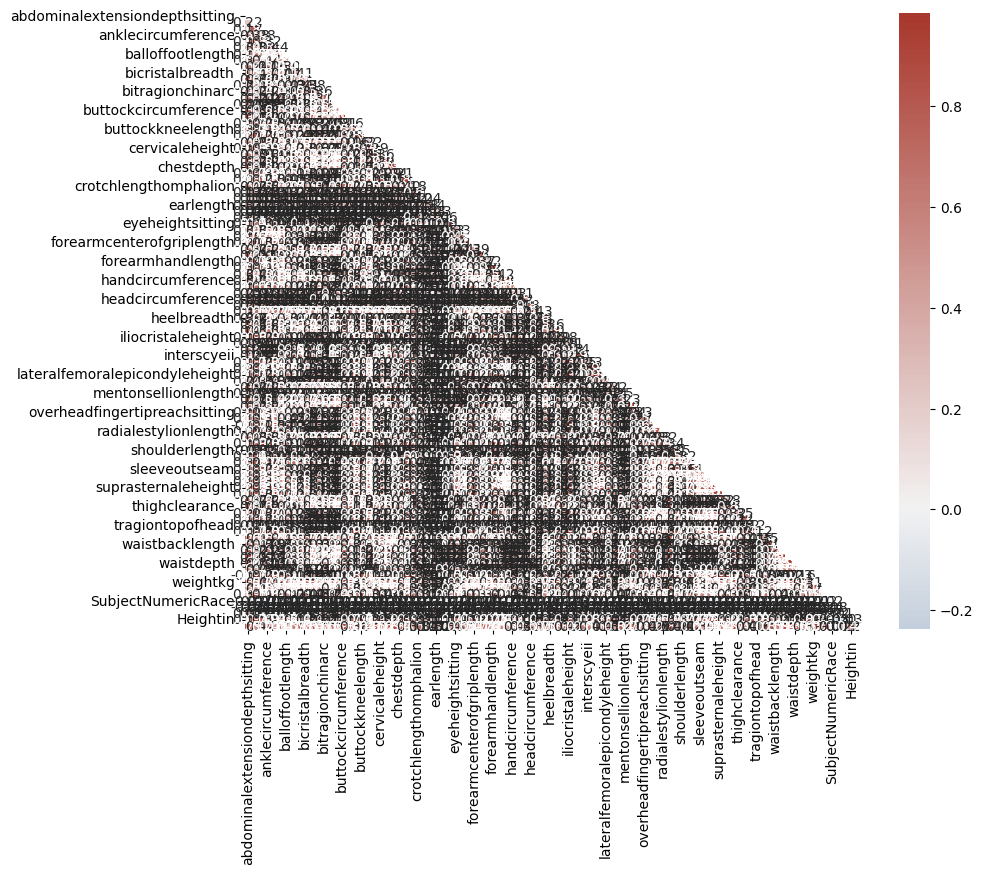

In [8]:
ansur_numerical = ansur[numerical_features]
plot_correlation_matrix(ansur_numerical, figsize=(10, 8))

#### Remove strong correlations

* Build matrix with absolute values so that we can filter out strong correlations (positive and negative)
* Create a boolean mask to subset the matrix

In [9]:
threshold = 0.9
to_drop = identify_correlated(ansur_numerical, threshold=threshold)
print(f"Found {len(to_drop)} features with correlation stronger than {threshold}")

Found 34 features with correlation stronger than 0.9


In [10]:
ansur_reduced = ansur_numerical.drop(to_drop, axis=1)
ansur_reduced.head()

,anklecircumference,balloffootcircumference,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockdepth,...,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,SubjectNumericRace,DODRace,Age,Heightin,Weightlbs
0,222,253,401,369,274,71,319,291,142,240,...,240,440,1054,175,853,1,1,41,71,180
1,220,245,394,338,257,67,344,320,135,232,...,225,371,1054,167,815,1,1,35,68,160
2,230,256,427,408,261,75,345,330,135,258,...,255,411,1041,180,831,2,2,42,68,205
3,230,262,401,359,262,73,328,309,143,242,...,205,399,968,176,793,1,1,31,66,175
4,247,267,435,356,263,80,340,310,138,275,...,214,379,1245,188,954,2,2,21,77,213


### Compare models

* Random Forest Regressor model
* Ansur dataset using all (98) numerical features
  * Train score = 0.989
  * Test score = 0.950
  * Model training and scoring took 11.6 seconds
* Ansur dataset using reduced (34) numerical features
  * Train score = 0.986
  * Test score = 0.935
  * Model training and scoring took 6.6 seconds
* The reduced feature dataset (34 features) had a R2 test score 1.5% worse than the full (98 features)

In [11]:
# Build feature and target (Weightlbs) arrays
X = ansur_numerical.drop('Weightlbs', axis=1)
y = ansur['Weightlbs']

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [13]:
%%time

# Init, fit, score
forest = RandomForestRegressor()
_ = forest.fit(X_train, y_train)

print(f"Training R2 score: {forest.score(X_train, y_train):.3f}")
print(f"Test R2 score: {forest.score(X_test, y_test):.3f}")

Training score: 0.989
Test score: 0.950
CPU times: user 11.4 s, sys: 22.4 ms, total: 11.4 s
Wall time: 11.6 s


In [15]:
# Build feature and target (Weightlbs) arrays
X = ansur_reduced.drop('Weightlbs', axis=1)
y = ansur['Weightlbs']

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [17]:
%time

# Init, fit, score
forest = RandomForestRegressor()
_ = forest.fit(X_train, y_train)

print(f"Training R2 score: {forest.score(X_train, y_train):.3f}")
print(f"Test R2 score: {forest.score(X_test, y_test):.3f}")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Training score: 0.986
Test score: 0.932
